Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc # Garbage Collector to help manage memory

# Set plot style
sns.set_style("whitegrid")

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


Optimasi Memori

In [2]:
def reduce_mem_usage(df):
    """ Iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else: # float types
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


#### Exploratory Data Analysis

In [3]:
def perform_eda(df, df_name, id_cols=[], target_col=None):
    """
    Performs a standard EDA process on a given dataframe.
    Includes: Info, Head, Missing Values, Descriptive Stats, Univariate Plots, Outlier Plots.
    """
    print(f"\n--- Starting EDA for {df_name} ---")

    # Apply memory reduction
    df = reduce_mem_usage(df)

    print("\n--- Basic Information ---")
    print(df.info())
    print("\n--- First 5 Rows ---")
    print(df.head())

    print("\n--- Missing Values (Percentage) ---")
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values[missing_values > 0] / len(df)) * 100
    if not missing_percentage.empty:
        print(missing_percentage.sort_values(ascending=False))
    else:
        print("No missing values found.")

    # --- Descriptive Statistics ---
    print("\n--- Descriptive Statistics for Numerical Features ---")
    print(df.select_dtypes(include=np.number).describe().transpose()) # Transpose for better readability

    # Check if there are any categorical columns before describing them
    categorical_cols_for_desc = df.select_dtypes(include='category')
    print("\n--- Descriptive Statistics for Categorical Features ---")
    if not categorical_cols_for_desc.empty:
        print(categorical_cols_for_desc.describe().transpose())
    else:
        print("No categorical columns found for descriptive statistics.")


    # --- Univariate Analysis: Numerical Features Distribution ---
    print("\n--- Univariate Analysis: Numerical Features Distribution ---")
    numerical_cols = df.select_dtypes(include=np.number).columns.drop(id_cols, errors='ignore')
    if target_col and target_col in numerical_cols:
        numerical_cols = numerical_cols.drop(target_col, errors='ignore')

    # Plot histograms for a sample of numerical columns to avoid too many plots
    n_cols_to_plot = min(len(numerical_cols), 5) # Plot up to 5 random numerical columns
    selected_numerical_cols = np.array([]) 
    if n_cols_to_plot > 0:
        selected_numerical_cols = np.random.choice(numerical_cols, n_cols_to_plot, replace=False)
        for col in selected_numerical_cols:
            plt.figure(figsize=(8, 5))
            sns.histplot(df[col].dropna(), kde=True, bins=50)
            plt.title(f'Distribution of {col} in {df_name}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
            plt.show()
    else:
        print("No numerical columns to plot (excluding IDs and target).")

    # --- Univariate Analysis: Categorical Features Distribution ---
    print("\n--- Univariate Analysis: Categorical Features Distribution ---")
    categorical_cols = df.select_dtypes(include='category').columns

    if not categorical_cols.empty:
        for col in categorical_cols:
            if df[col].nunique() < 50: 
                plt.figure(figsize=(10, 6))
                sns.countplot(y=col, data=df, order=df[col].value_counts().index)
                plt.title(f'Distribution of {col} in {df_name}')
                plt.xlabel('Count')
                plt.ylabel(col)
                plt.show()
            else:
                print(f"Skipping countplot for {col} in {df_name} due to high number of unique categories ({df[col].nunique()}).")
    else:
        print("No categorical columns found for univariate analysis.")

    # --- Outlier Detection (using Box Plots for key numerical features) ---
    print("\n--- Outlier Detection (using Box Plots) ---")
    outlier_cols_sample = selected_numerical_cols 

    # Change .empty to len() == 0 for NumPy array check
    if len(outlier_cols_sample) > 0: 
        for col in outlier_cols_sample:
            plt.figure(figsize=(8, 5))
            sns.boxplot(x=df[col].dropna())
            plt.title(f'Box Plot of {col} for Outlier Detection in {df_name}')
            plt.show()
    else:
        print("No numerical columns selected for outlier detection plots.")


    # --- Bivariate Analysis (if a target column is specified) ---
    if target_col and target_col in df.columns:
        print(f"\n--- Bivariate Analysis: Relationship with {target_col} ---")
        # Numerical Features vs. TARGET
        # Change .empty to len() == 0 for NumPy array check
        if len(selected_numerical_cols) > 0:
            for col in selected_numerical_cols:
                plt.figure(figsize=(8, 5))
                sns.boxplot(x=target_col, y=col, data=df)
                plt.title(f'{col} vs. {target_col} in {df_name}')
                plt.show()
        else:
            print("No numerical columns to plot against target.")

        # Categorical Features vs. TARGET
        if not categorical_cols.empty:
            for col in categorical_cols:
                if df[col].nunique() < 20: # Limit to categories with fewer unique values
                    plt.figure(figsize=(10, 6))
                    sns.barplot(x=col, y=target_col, data=df, ci=None)
                    plt.title(f'{target_col} Rate by {col} in {df_name}')
                    plt.ylabel(f'{target_col} Rate (TARGET = 1)')
                    plt.xticks(rotation=45, ha='right')
                    plt.show()
                else:
                    print(f"Skipping bar plot for {col} vs {target_col} in {df_name} due to high number of unique categories.")
        else:
            print("No categorical columns to plot against target.")

    # --- Correlation Heatmap (for key numerical features) ---
    print(f"\n--- Correlation Heatmap for {df_name} (Sample of Numerical Features) ---")
    # Limit features for correlation to avoid very large heatmaps
    corr_df = df.select_dtypes(include=np.number)
    # Reduce columns if too many (e.g., take top correlated with target if exists, or a random sample)
    if corr_df.shape[1] > 15:
        # If target_col exists, pick top correlated. Otherwise, random random.choice(corr_df.columns, 15, replace=False)
        if target_col and target_col in corr_df.columns:
            top_corr_cols = corr_df.corrwith(corr_df[target_col]).abs().sort_values(ascending=False).index[:15]
            corr_df = corr_df[top_corr_cols]
        else:
            corr_df = corr_df[np.random.choice(corr_df.columns, 15, replace=False)]

    if corr_df.shape[1] > 1: # Ensure there's more than one column for correlation
        correlation_matrix = corr_df.corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title(f'Correlation Matrix of Key Numerical Features in {df_name}')
        plt.show()
    else:
        print("Not enough numerical columns to plot a correlation heatmap.")

    print(f"--- Finished EDA for {df_name} ---")

Jumlah data per kelas TARGET:
TARGET
0    282686
1     24825
Name: count, dtype: int64

Persentase data per kelas TARGET:
TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64


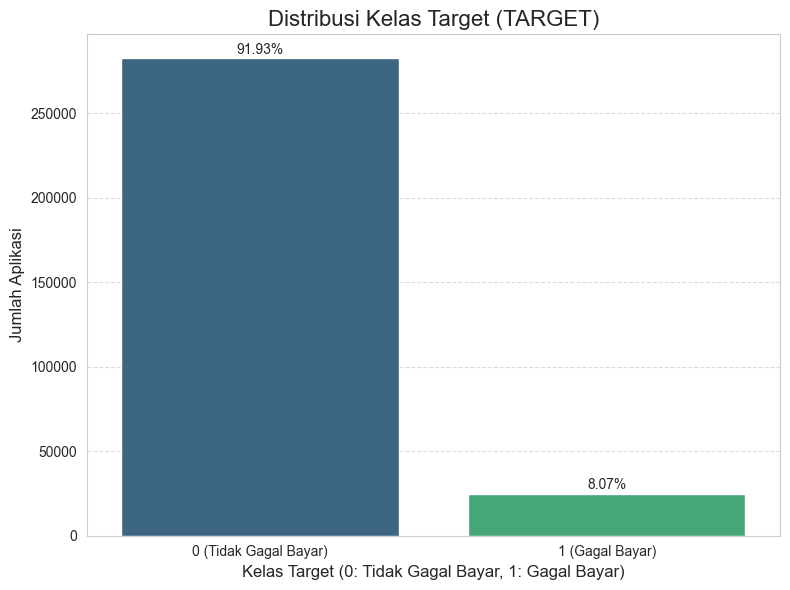

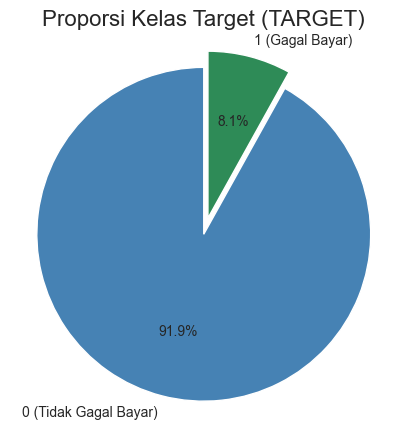

In [10]:
file_path = 'application_train.csv'

try:
    df_train = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found. Please check the file path.")
    exit()

target_counts = df_train['TARGET'].value_counts()
target_percentage = df_train['TARGET'].value_counts(normalize=True) * 100

print("Jumlah data per kelas TARGET:")
print(target_counts)
print("\nPersentase data per kelas TARGET:")
print(target_percentage)

# Membuat visualisasi
plt.figure(figsize=(8, 6))
sns.barplot(x=target_counts.index, y=target_counts.values, palette='viridis')

# Menambahkan label dan judul
plt.title('Distribusi Kelas Target (TARGET)', fontsize=16)
plt.xlabel('Kelas Target (0: Tidak Gagal Bayar, 1: Gagal Bayar)', fontsize=12)
plt.ylabel('Jumlah Aplikasi', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['0 (Tidak Gagal Bayar)', '1 (Gagal Bayar)'])

# Menambahkan teks persentase di atas setiap bar
for index, value in enumerate(target_counts.values):
    plt.text(index, value + 1000, f'{target_percentage.iloc[index]:.2f}%',
             ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualisasi dalam bentuk pie chart (opsional, untuk melihat proporsi)
plt.figure(figsize=(5,5))
plt.pie(target_counts, labels=['0 (Tidak Gagal Bayar)', '1 (Gagal Bayar)'],
        autopct='%1.1f%%', startangle=90, colors=['steelblue','seagreen'], explode=(0, 0.1))
plt.title('Proporsi Kelas Target (TARGET)', fontsize=16)
plt.axis('equal') # Memastikan pie chart berbentuk lingkaran
plt.show()

--- EDA for application_train.csv ---

--- Starting EDA for application_train.csv ---
Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%

--- Basic Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: category(16), float16(61), float32(4), int16(2), int32(2), int8(37)
memory usage: 59.5 MB
None

--- First 5 Rows ---
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y        

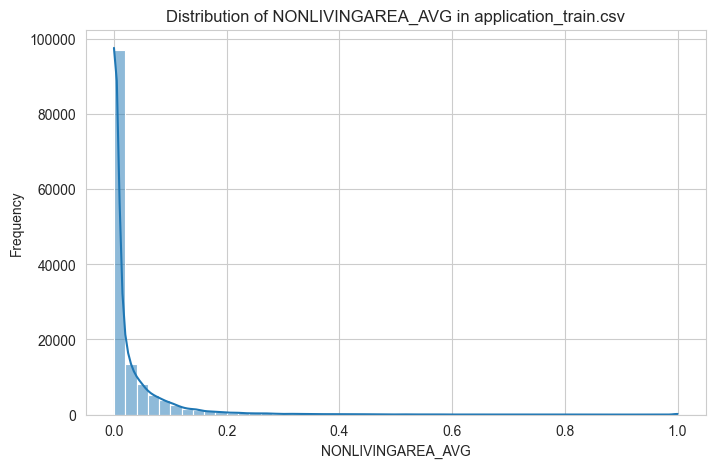

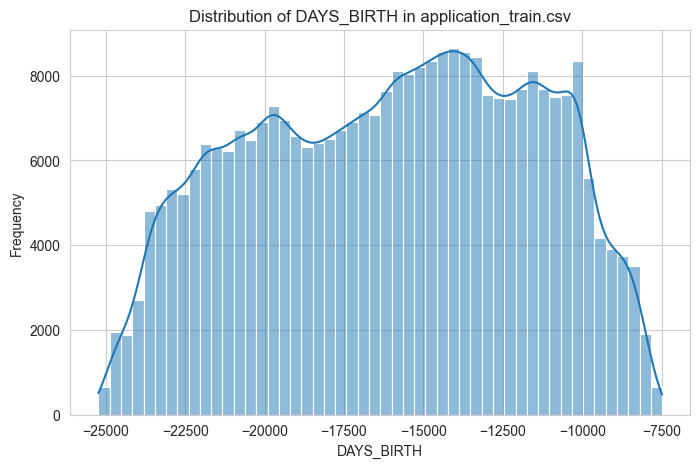

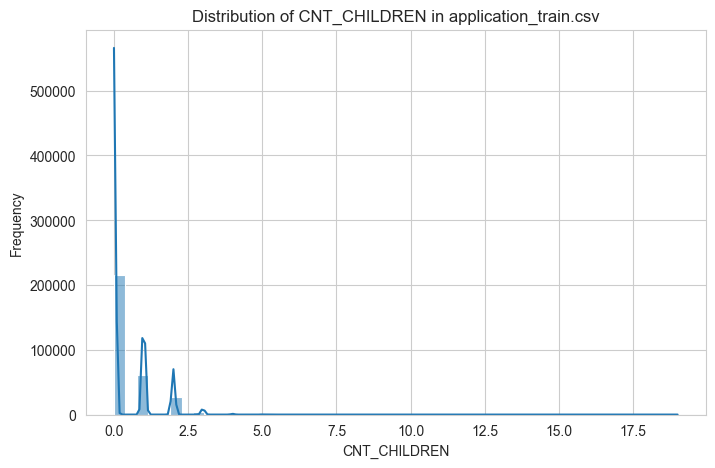

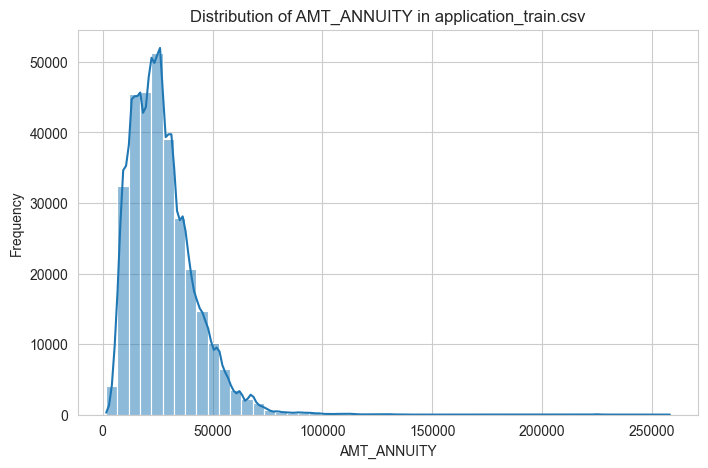

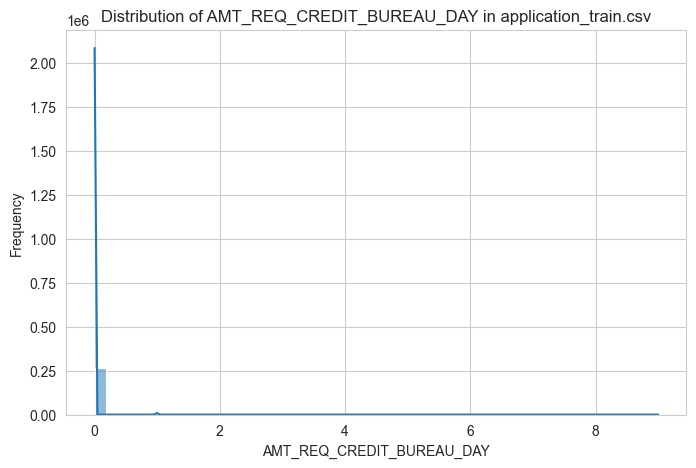


--- Univariate Analysis: Categorical Features Distribution ---


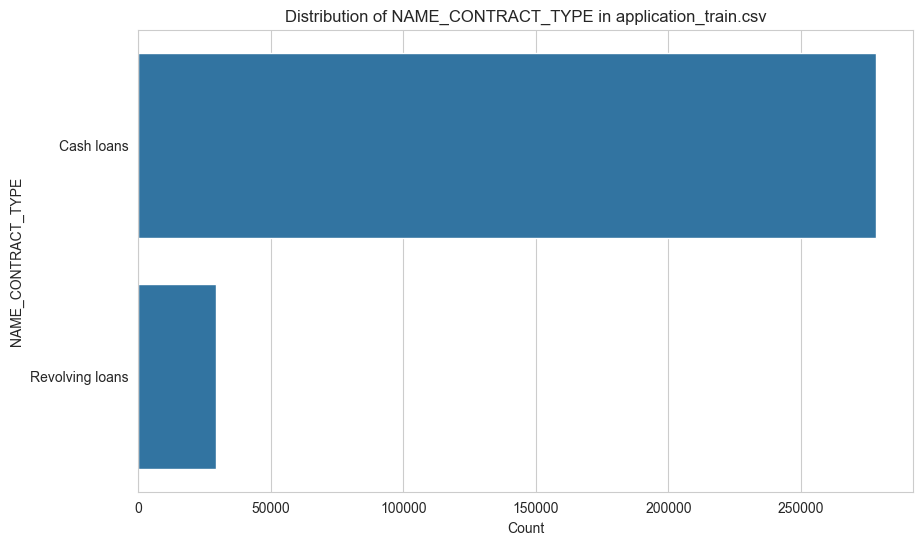

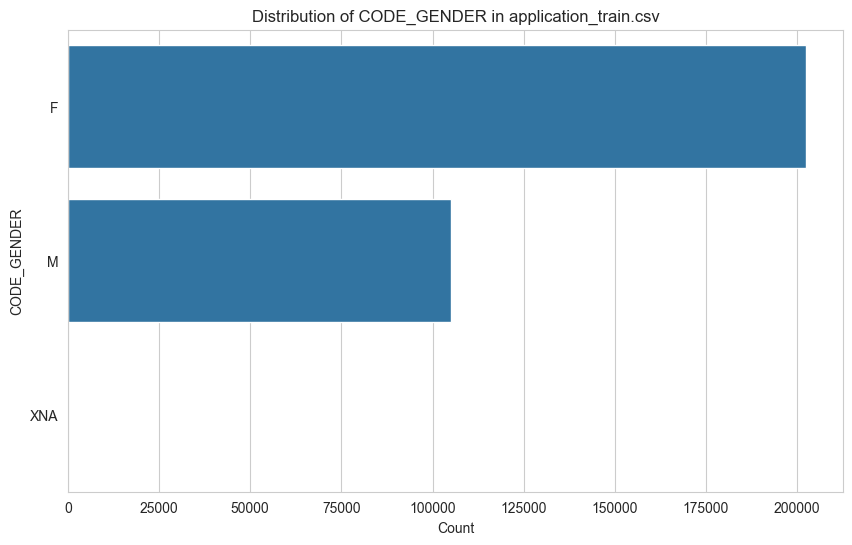

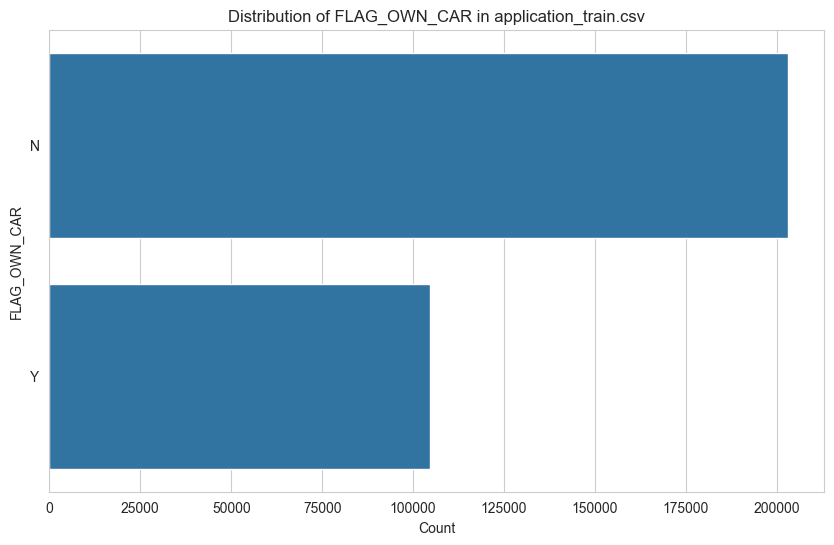

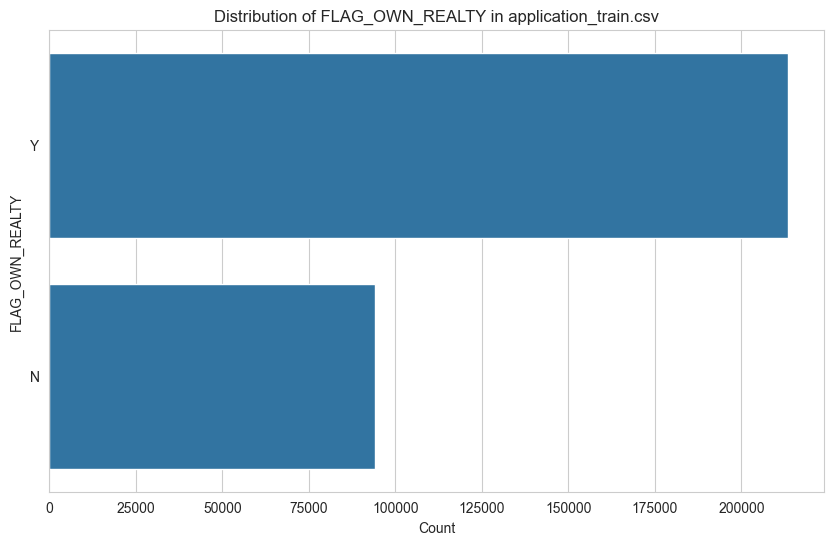

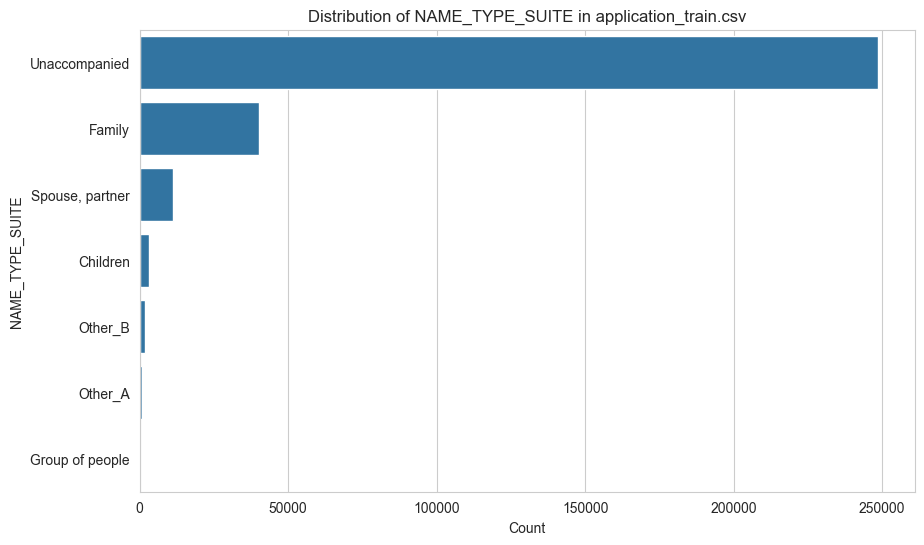

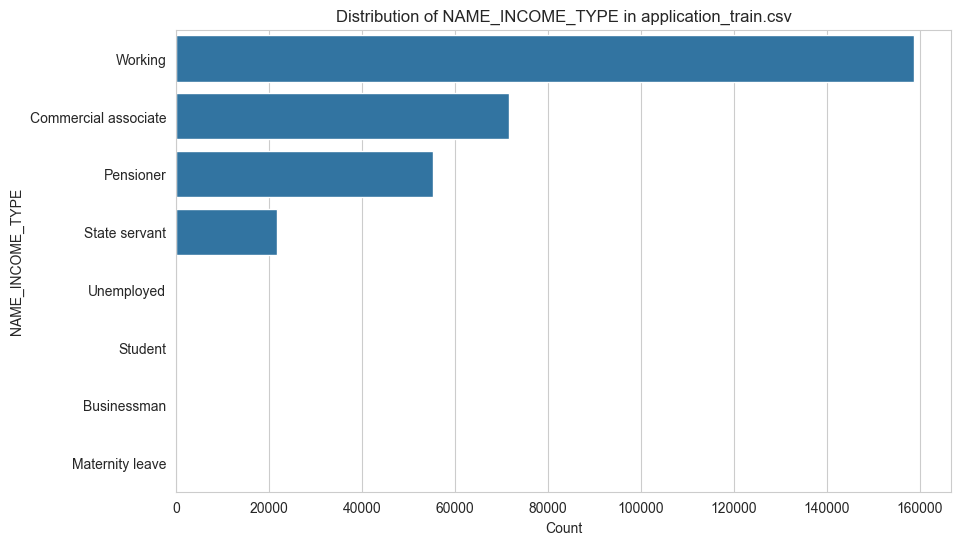

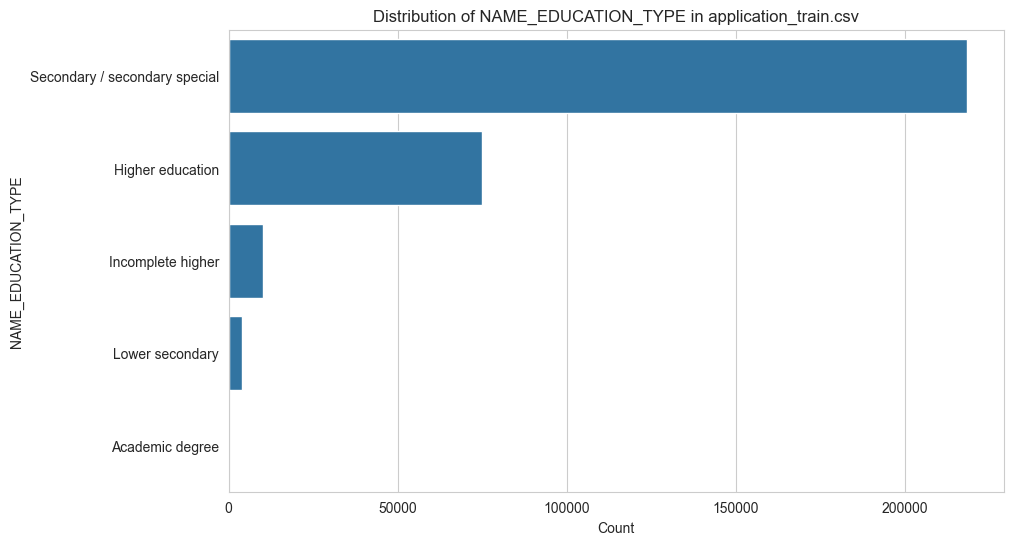

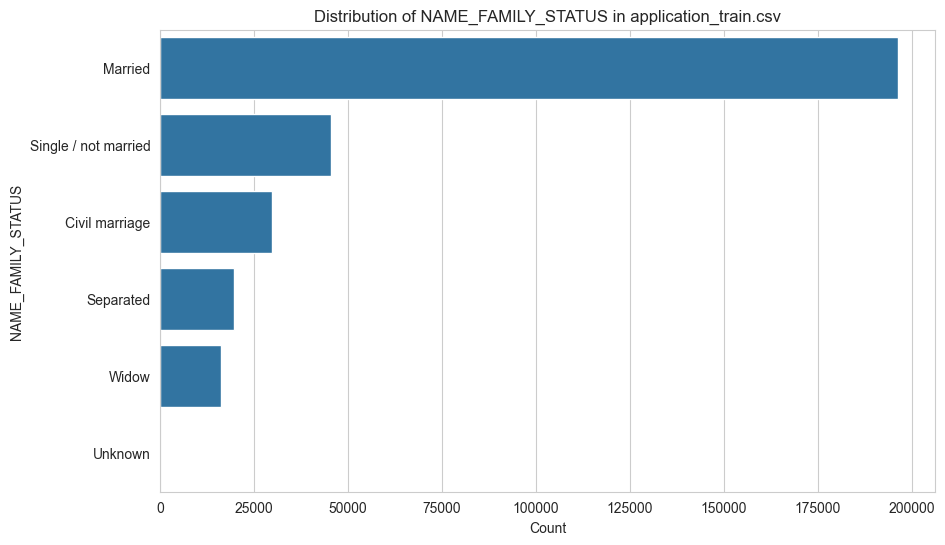

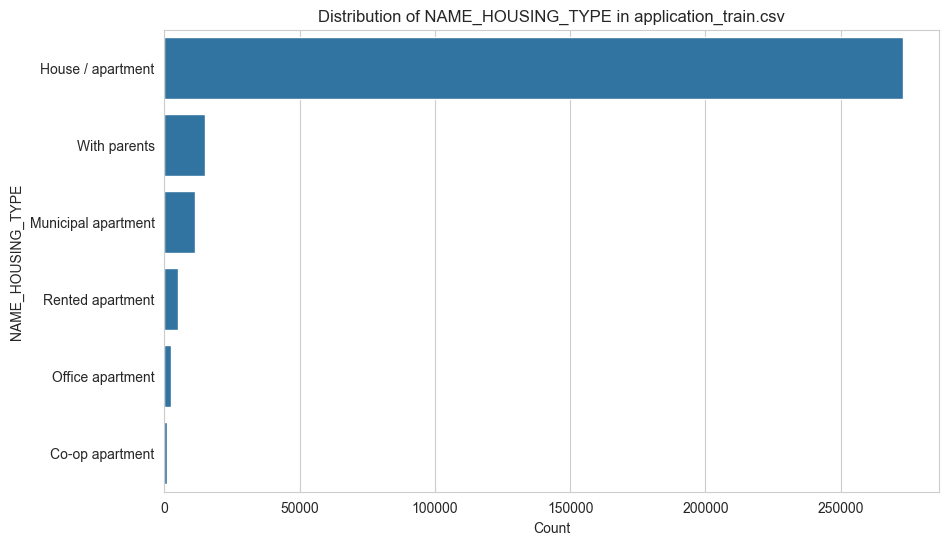

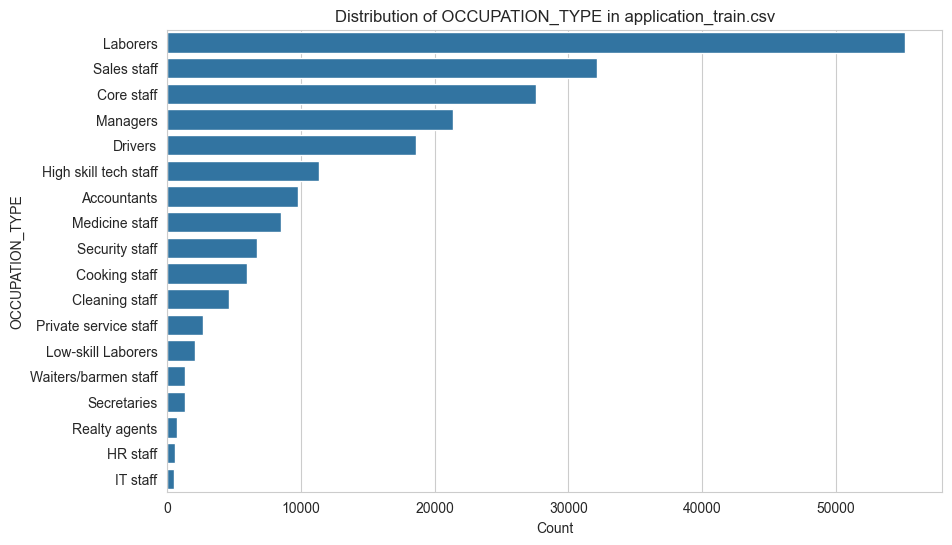

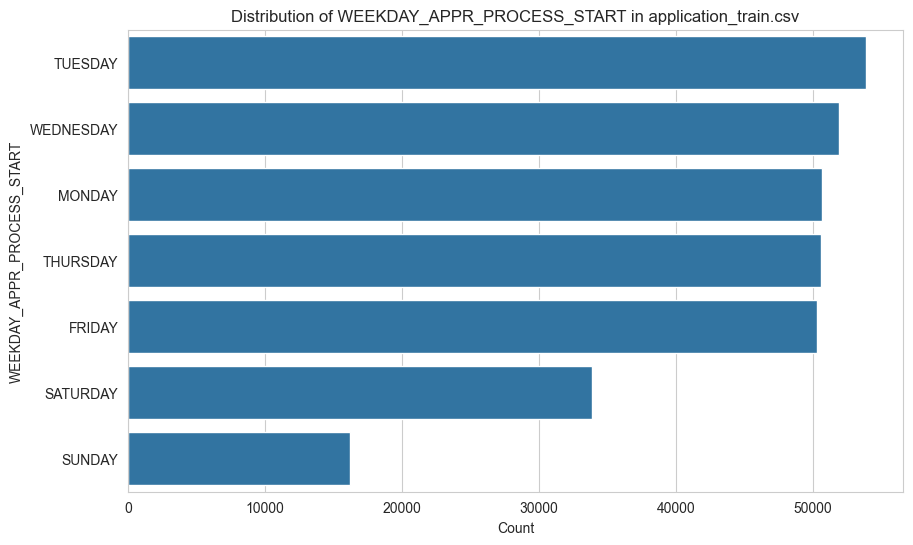

Skipping countplot for ORGANIZATION_TYPE in application_train.csv due to high number of unique categories (58).


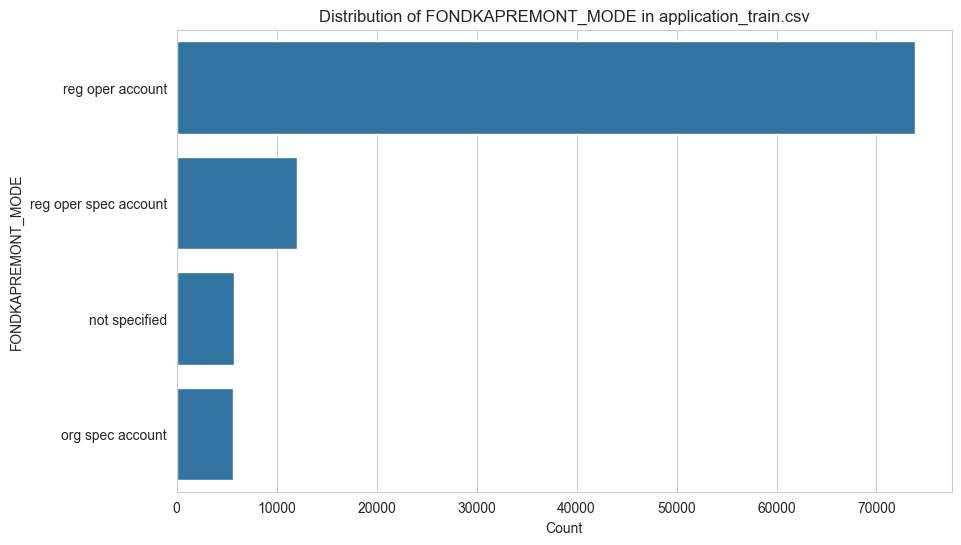

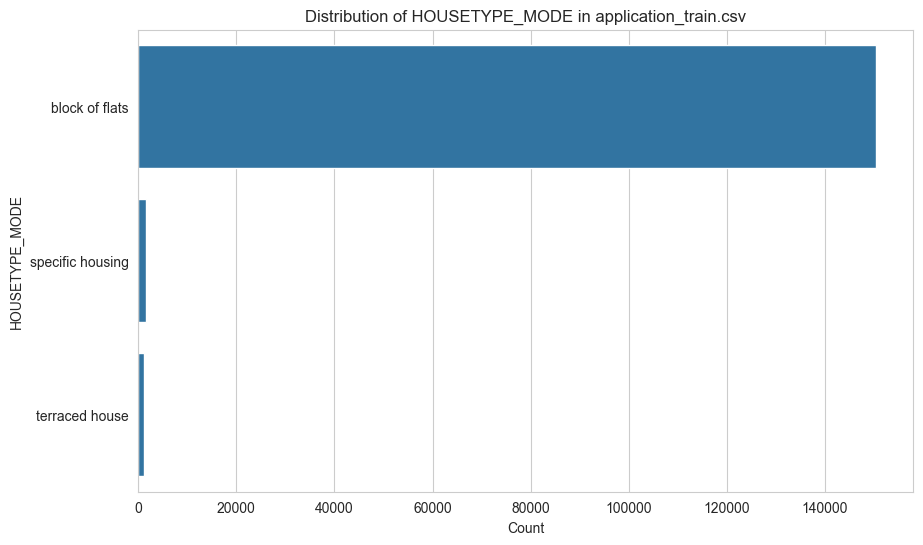

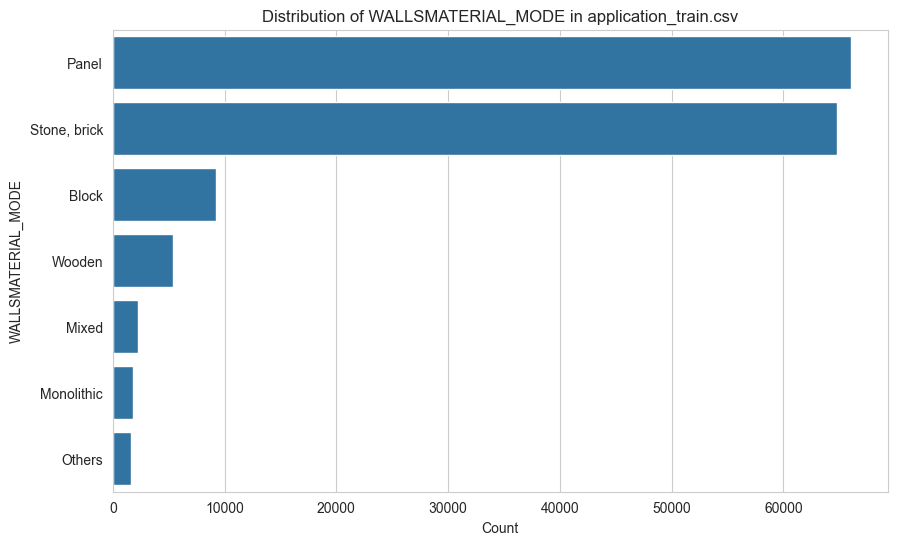

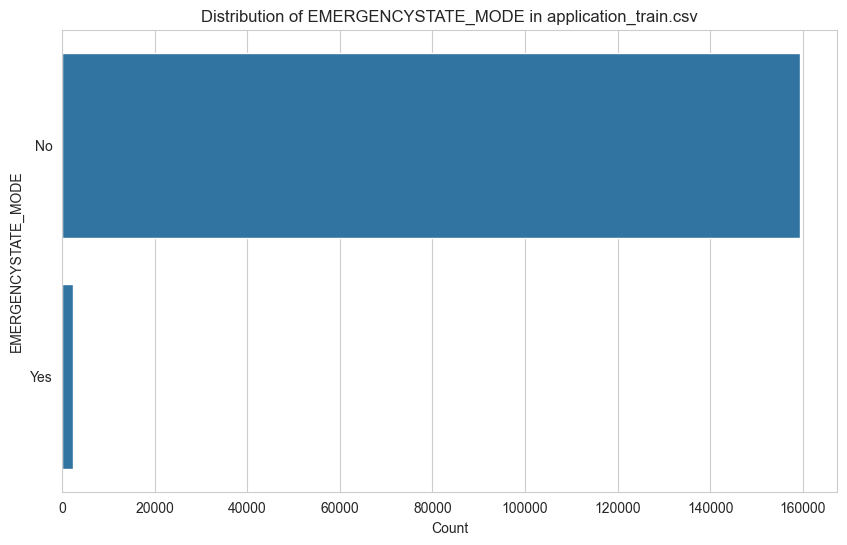


--- Outlier Detection (using Box Plots) ---


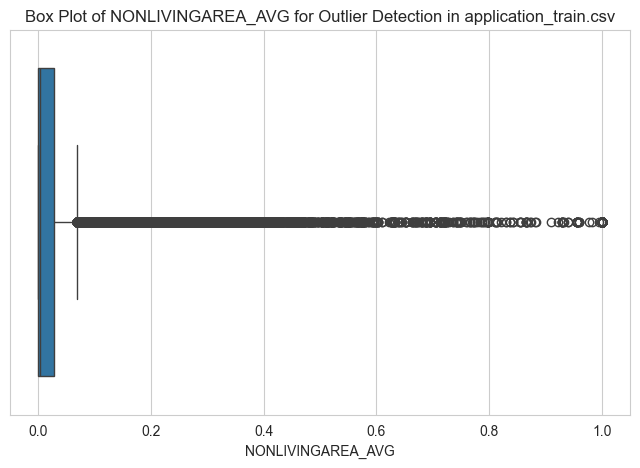

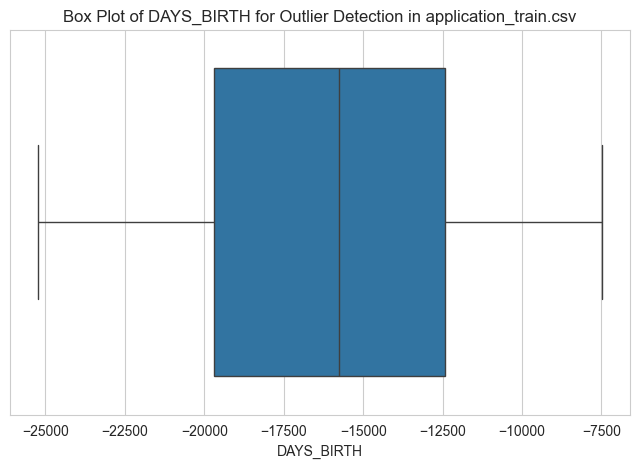

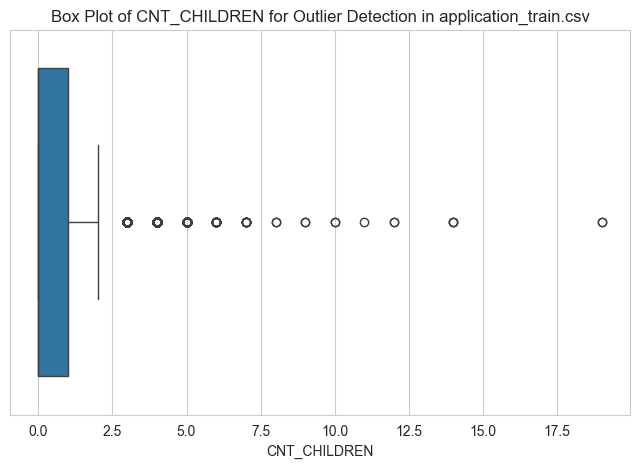

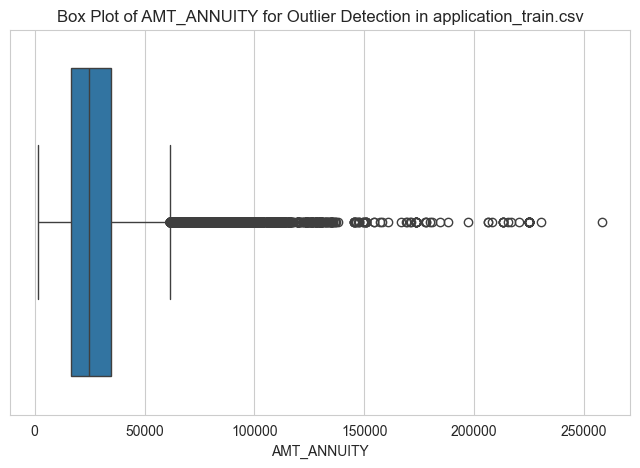

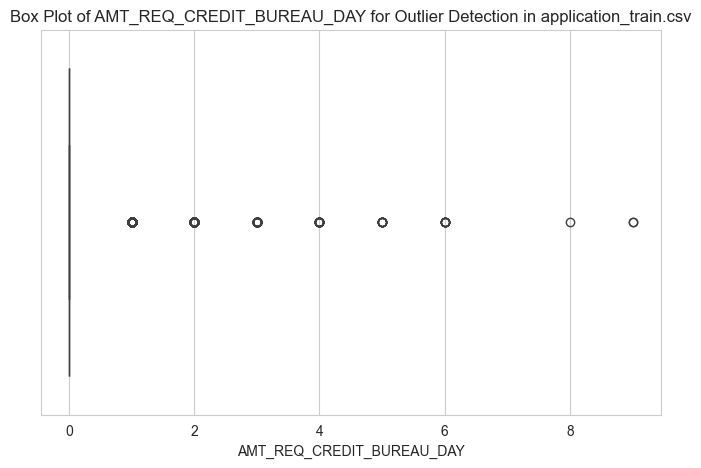


--- Bivariate Analysis: Relationship with TARGET ---


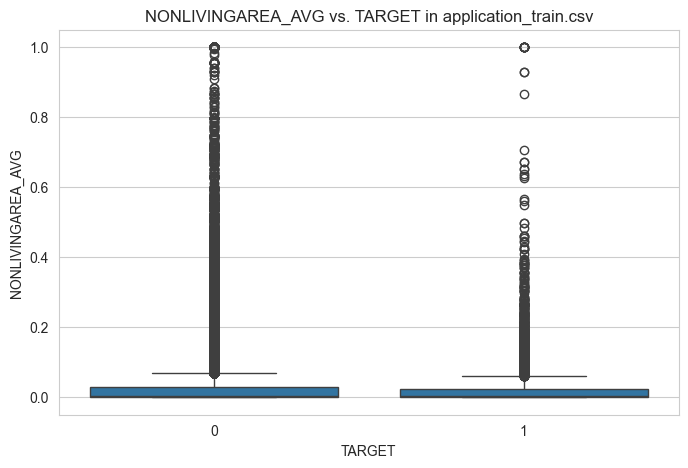

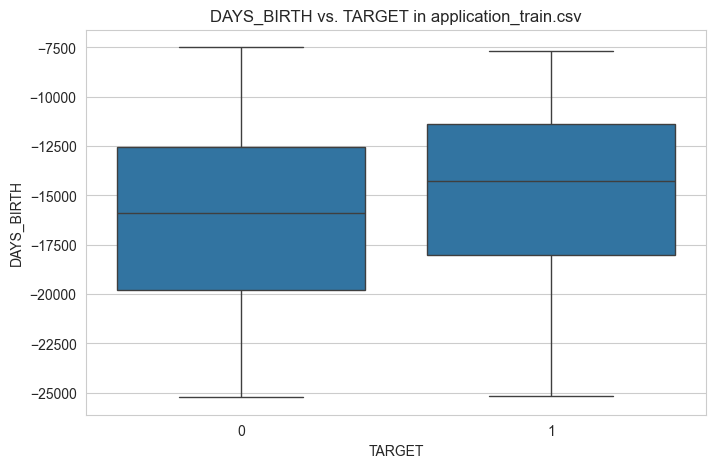

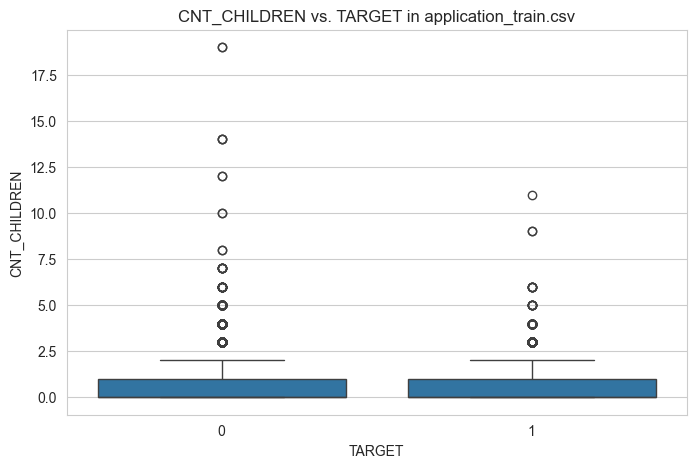

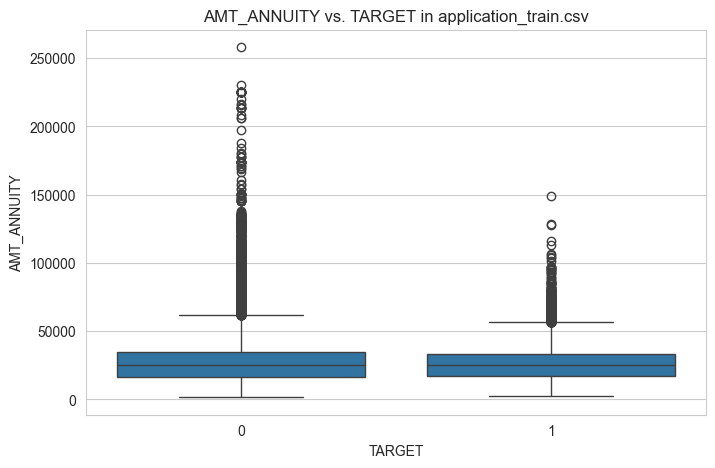

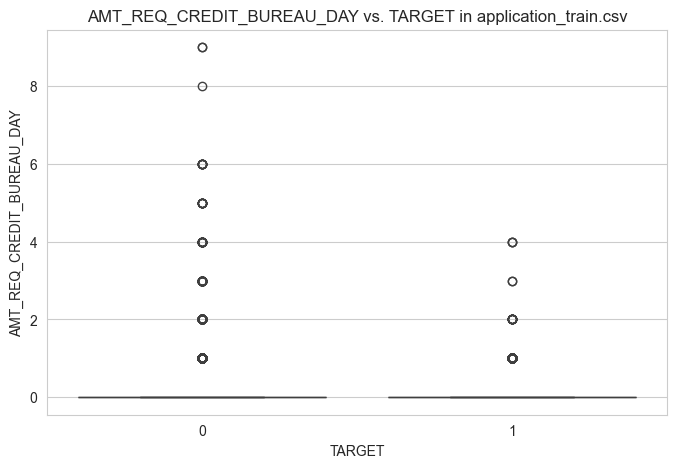

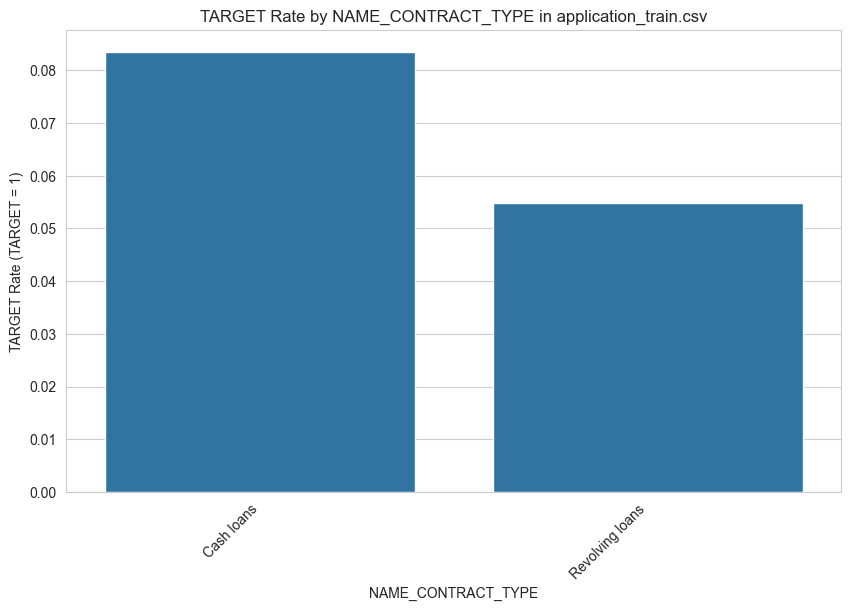

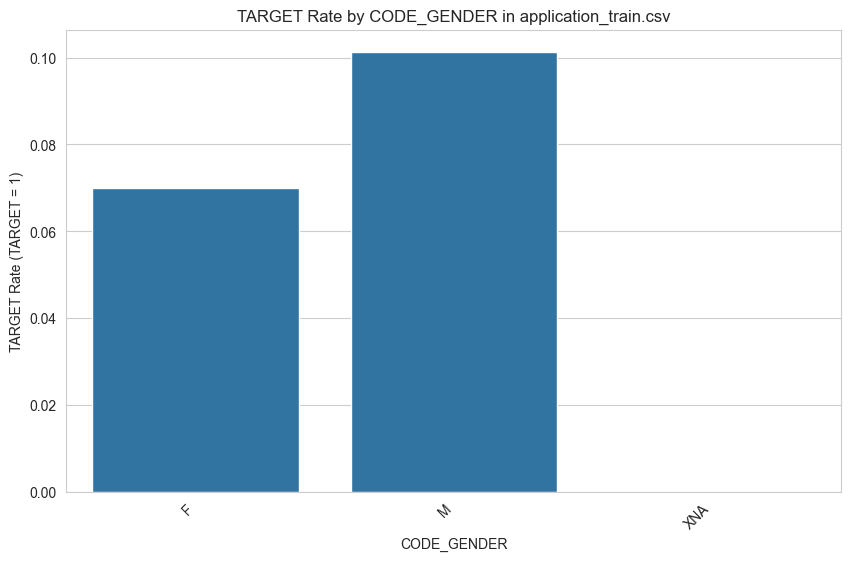

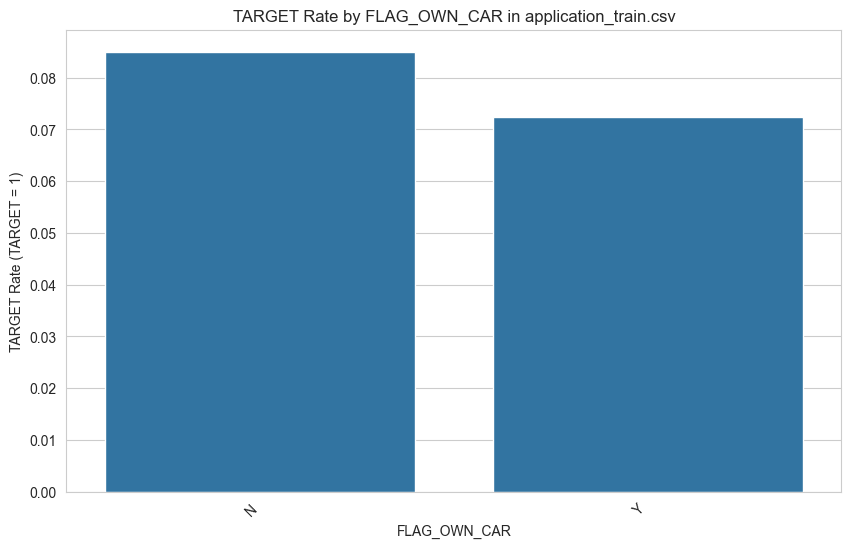

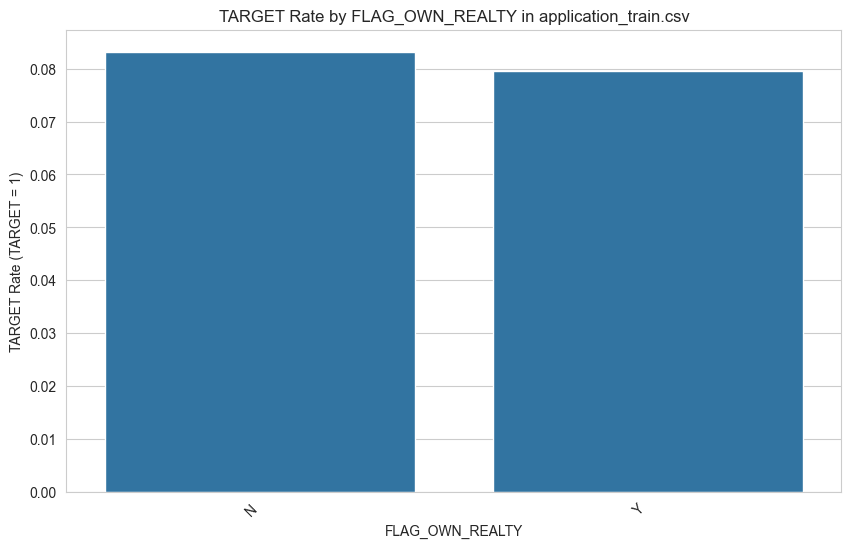

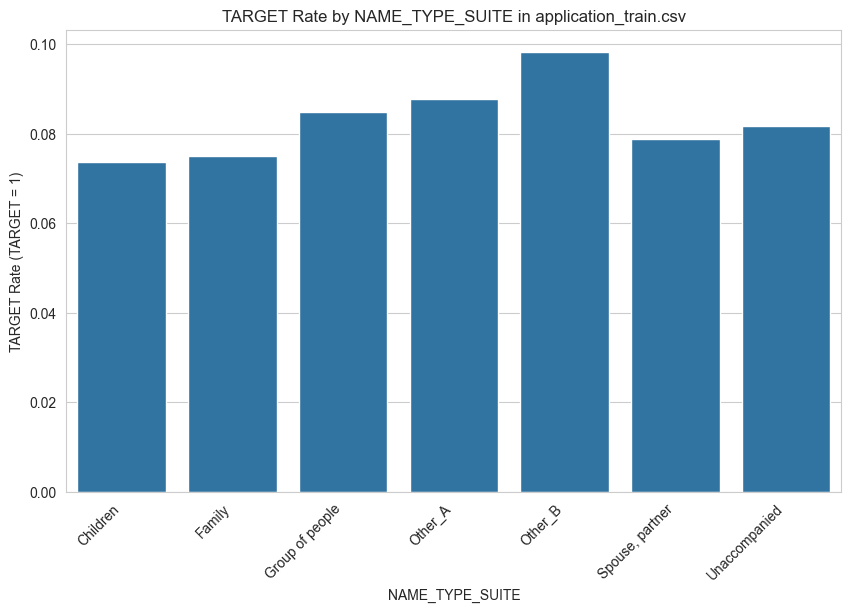

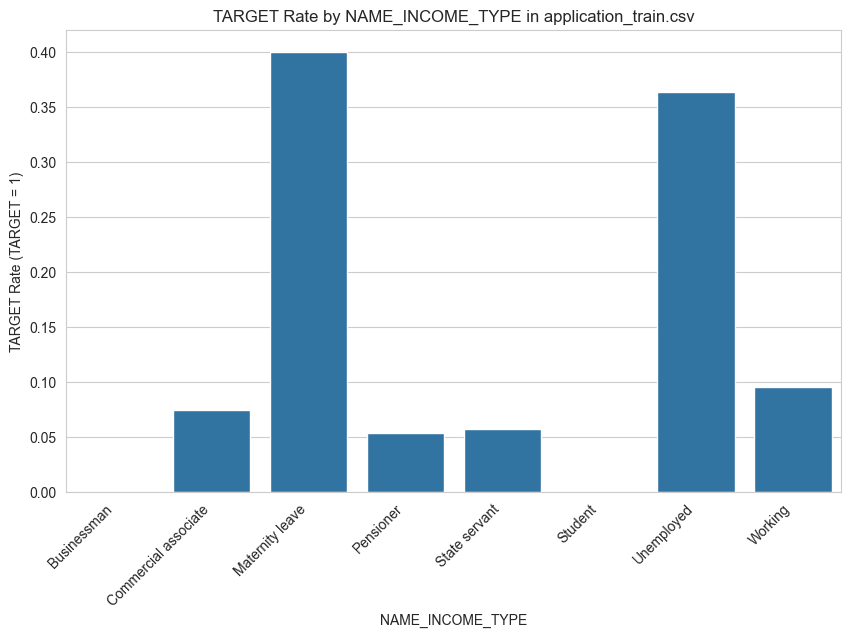

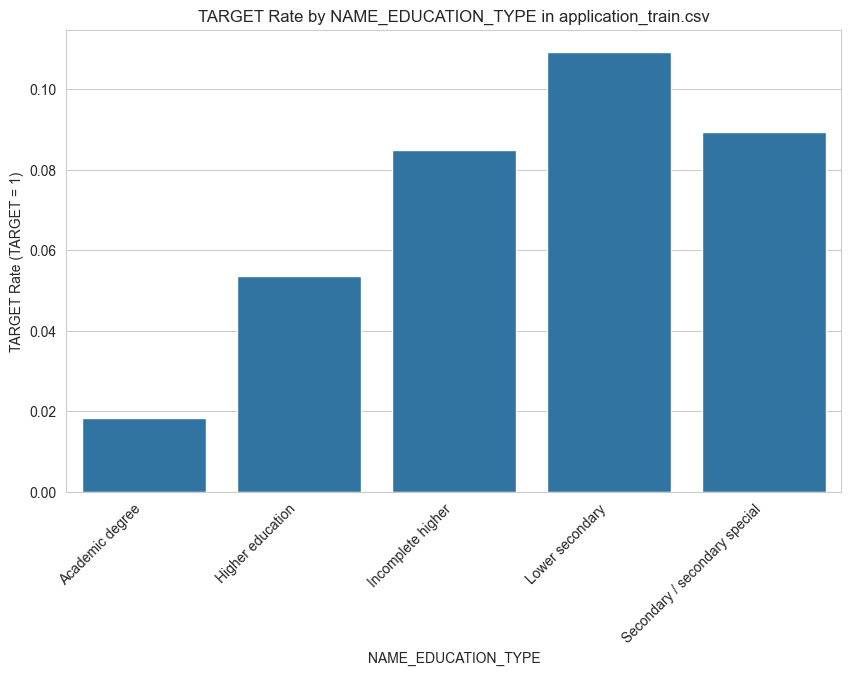

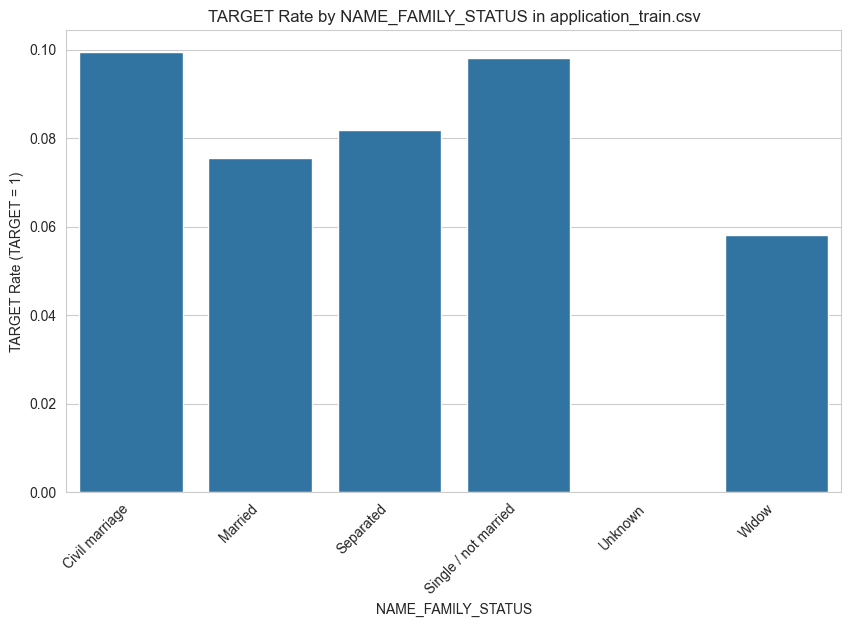

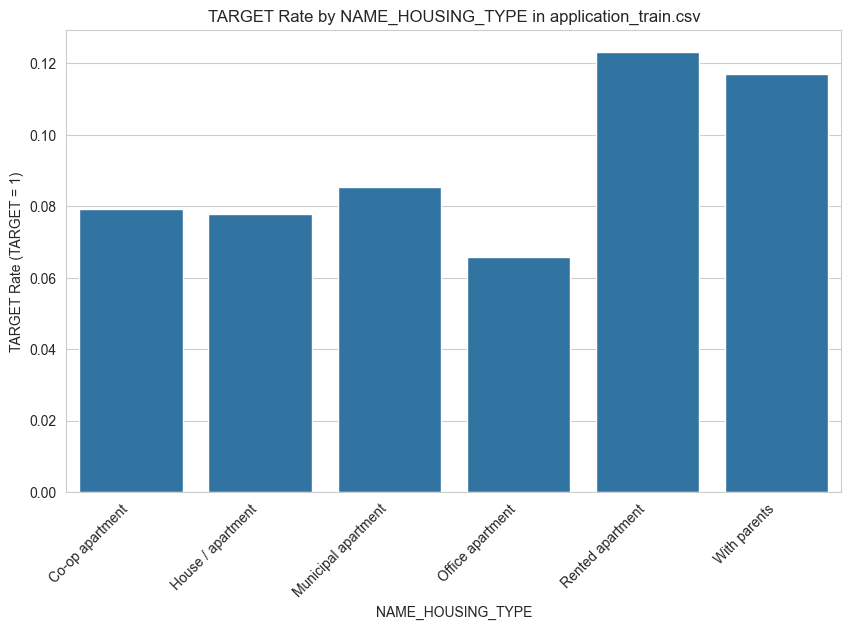

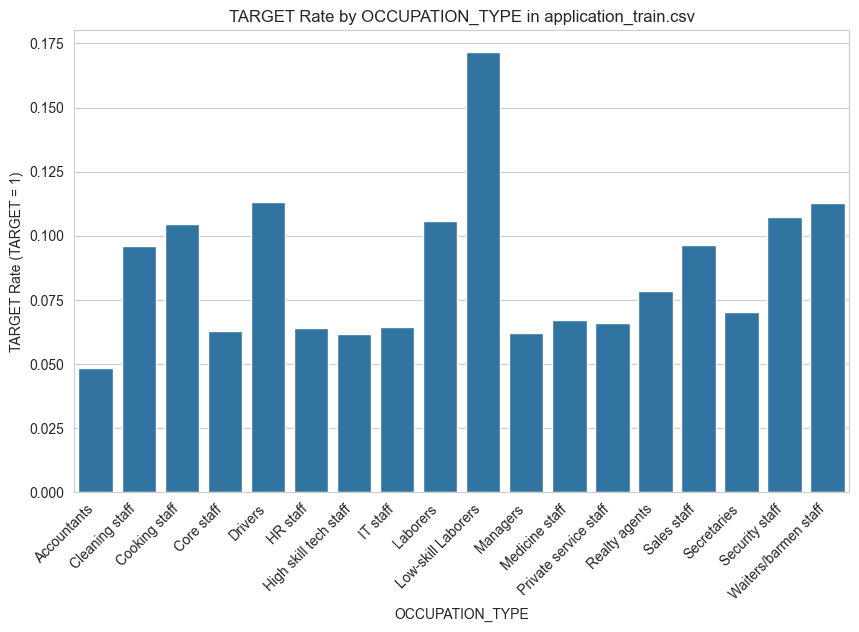

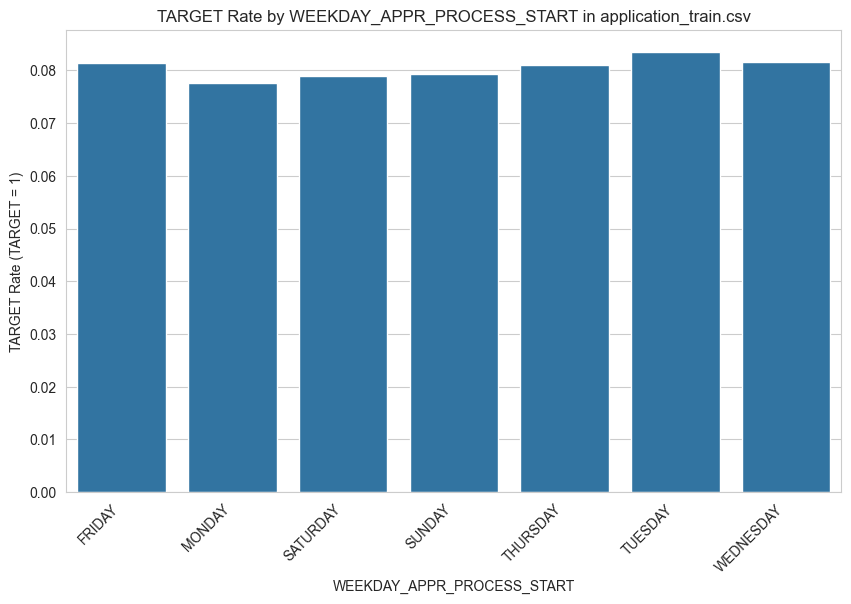

Skipping bar plot for ORGANIZATION_TYPE vs TARGET in application_train.csv due to high number of unique categories.


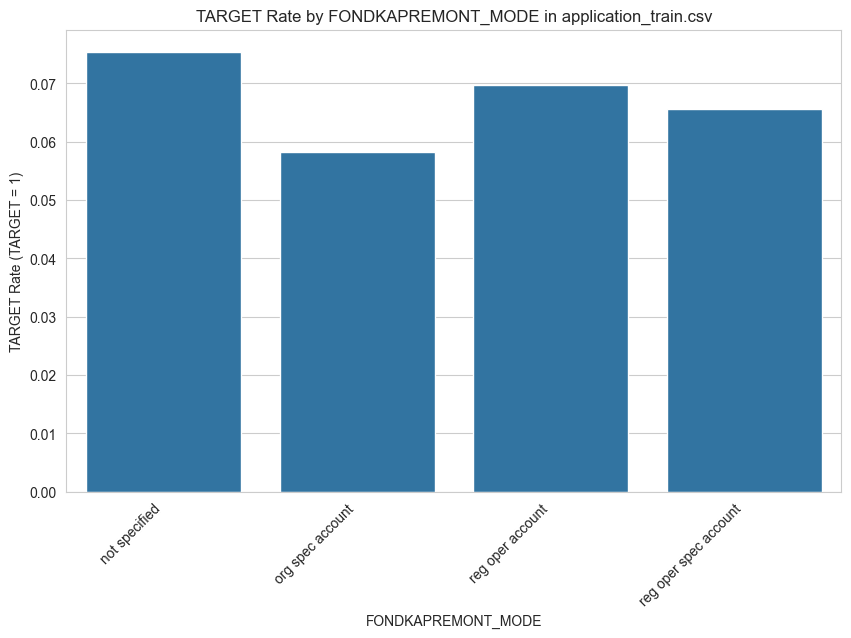

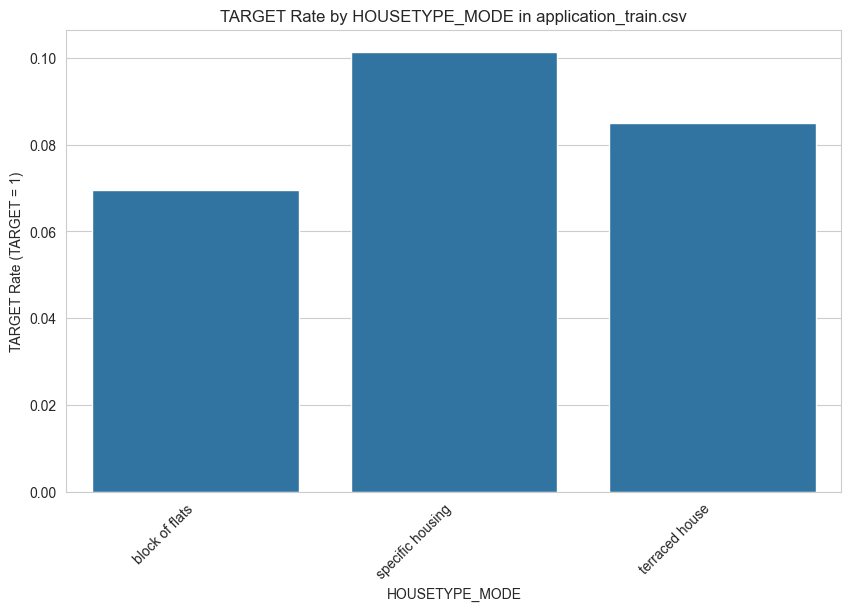

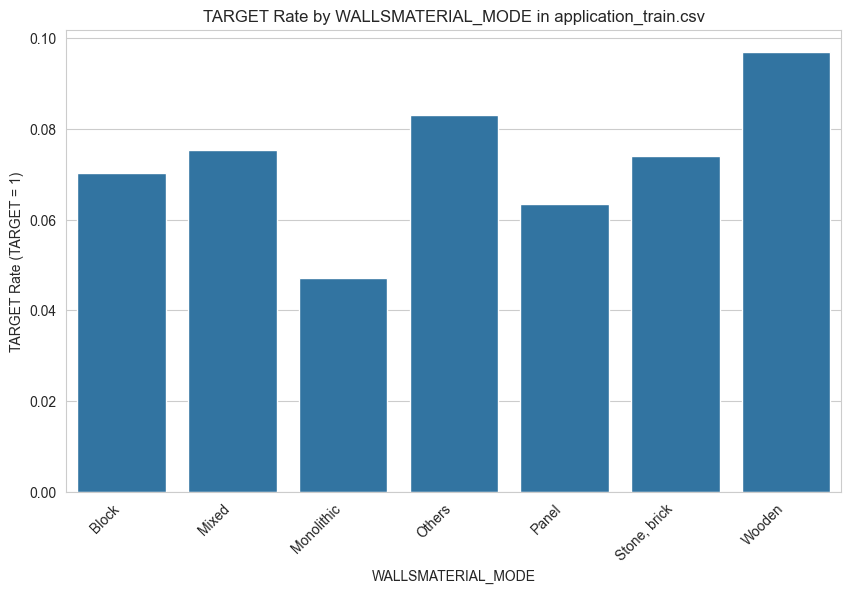

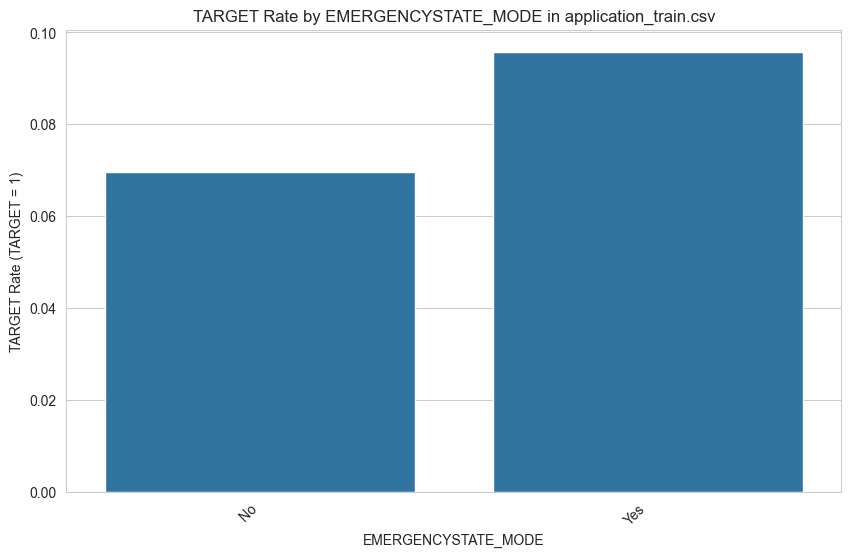


--- Correlation Heatmap for application_train.csv (Sample of Numerical Features) ---


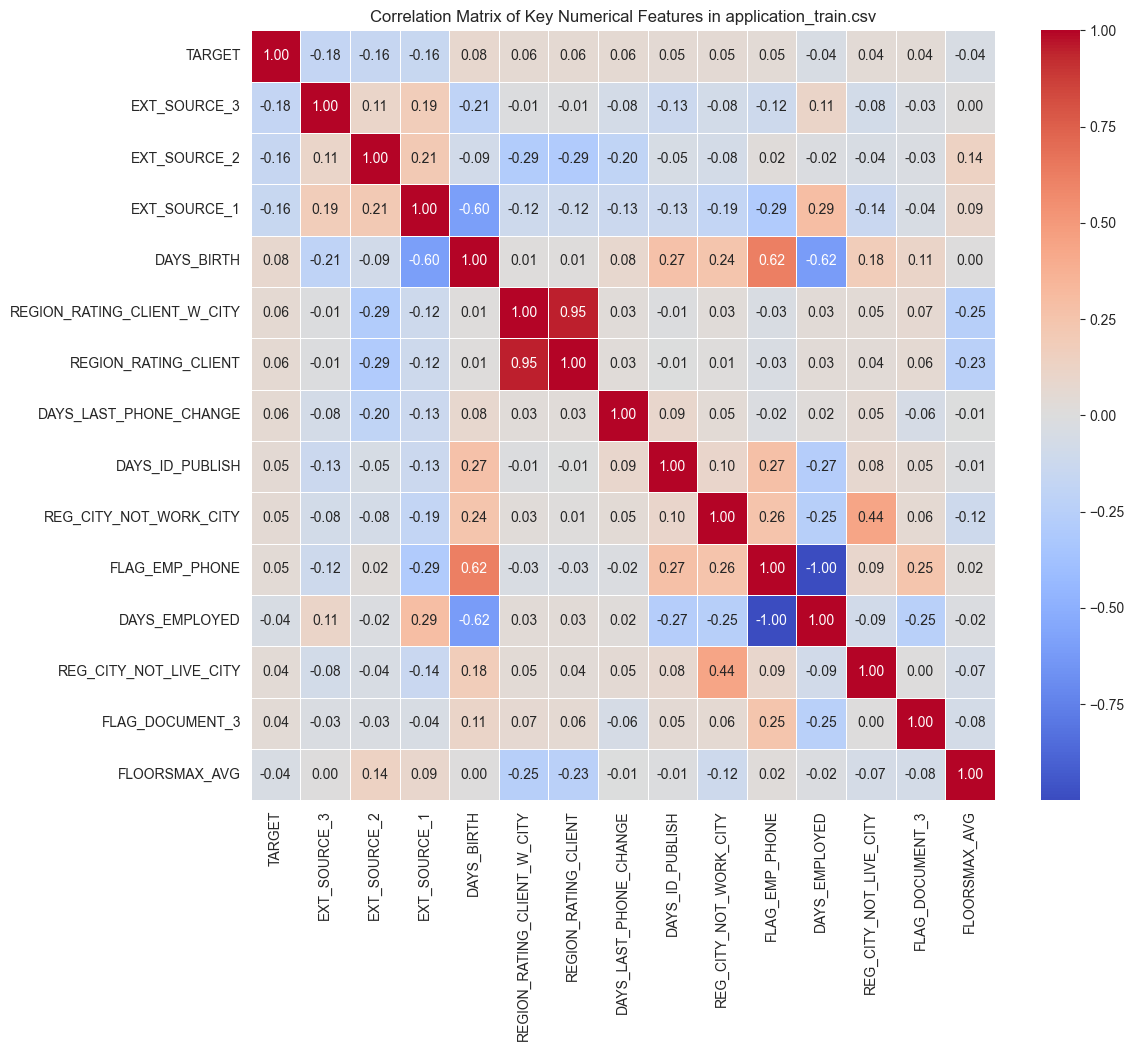

--- Finished EDA for application_train.csv ---


In [4]:
print("--- EDA for application_train.csv ---")
try:
    app_train = pd.read_csv('application_train.csv')
    perform_eda(app_train, 'application_train.csv', id_cols=['SK_ID_CURR'], target_col='TARGET')
    del app_train 
    gc.collect() 
except FileNotFoundError:
    print("Error: application_train.csv not found. Please ensure the file is in the correct directory.")

In [ ]:
print("\n--- EDA for application_test.csv ---")
try:
    app_test = pd.read_csv('application_test.csv')
    perform_eda(app_test, 'application_test.csv', id_cols=['SK_ID_CURR']) # No target column
    del app_test
    gc.collect()
except FileNotFoundError:
    print("Error: application_test.csv not found.")

In [ ]:
print("\n--- EDA for bureau.csv ---")
try:
    bureau = pd.read_csv('bureau.csv')
    perform_eda(bureau, 'bureau.csv', id_cols=['SK_ID_CURR', 'SK_ID_BUREAU'])
    del bureau
    gc.collect()
except FileNotFoundError:
    print("Error: bureau.csv not found.")

In [ ]:
print("\n--- EDA for bureau_balance.csv ---")
try:
    bureau_balance = pd.read_csv('bureau_balance.csv')
    perform_eda(bureau_balance, 'bureau_balance.csv', id_cols=['SK_ID_BUREAU'])
    del bureau_balance
    gc.collect()
except FileNotFoundError:
    print("Error: bureau_balance.csv not found.")

In [ ]:
print("\n--- EDA for POS_CASH_balance.csv ---")
try:
    pos_cash_balance = pd.read_csv('POS_CASH_balance.csv')
    perform_eda(pos_cash_balance, 'POS_CASH_balance.csv', id_cols=['SK_ID_CURR', 'SK_ID_PREV'])
    del pos_cash_balance
    gc.collect()
except FileNotFoundError:
    print("Error: POS_CASH_balance.csv not found.")

In [ ]:
print("\n--- EDA for credit_card_balance.csv ---")
try:
    credit_card_balance = pd.read_csv('credit_card_balance.csv')
    perform_eda(credit_card_balance, 'credit_card_balance.csv', id_cols=['SK_ID_CURR', 'SK_ID_PREV'])
    del credit_card_balance
    gc.collect()
except FileNotFoundError:
    print("Error: credit_card_balance.csv not found.")

In [ ]:
print("\n--- EDA for previous_application.csv ---")
try:
    previous_application = pd.read_csv('previous_application.csv')
    perform_eda(previous_application, 'previous_application.csv', id_cols=['SK_ID_CURR', 'SK_ID_PREV'])
    del previous_application
    gc.collect()
except FileNotFoundError:
    print("Error: previous_application.csv not found.")

In [ ]:
print("\n--- EDA for installments_payments.csv ---")
try:
    installments_payments = pd.read_csv('installments_payments.csv')
    perform_eda(installments_payments, 'installments_payments.csv', id_cols=['SK_ID_CURR', 'SK_ID_PREV'])
    del installments_payments
    gc.collect()
except FileNotFoundError:
    print("Error: installments_payments.csv not found.")

In [ ]:
print("\n--- HomeCredit_columns_description.csv ---")
try:
    column_descriptions = pd.read_csv('HomeCredit_columns_description.csv', encoding='latin1') 
    print("HomeCredit_columns_description.csv loaded successfully!")
    print("\n--- Sample Column Descriptions ---")
    print(column_descriptions.head())
    del column_descriptions
    gc.collect()
except FileNotFoundError:
    print("Error: HomeCredit_columns_description.csv not found.")